# STEP 3 - RESULT VISUALIZATION

*!!! NOTICE !!! This visualization file takes the output of Black Hole Algorithm as an example.*

If users want to check the output of other algorithms, please change `in_path` parameter to corresponding name at **section 3.4 - 3.6**.

## 3.1. Set fixed parameters

In [59]:
# import necessary libraries
import pandas as pd
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.animation as ani
from matplotlib.animation import PillowWriter
%matplotlib inline

# All sensor node information stored in `inputs.csv`
input_data_path = "../input/inputs.csv"
# The complete solution flight path stored in `final_output.csv`
output_data_path = "../output/final_output.csv"
# The ensemble output data stored in `ensemble_output.csv`
ensemble_path = "../output/ensemble_output.csv"
# The number of files (also can be considered as the number of PDVs)
file_num = 2

## 3.2. Recharge situation check

In [60]:
def rechargeCheck(in_path="../input/inputs.csv", out_path="../output/final_output.csv",
             plot_init_sns=False, plot_final_sns=False, plot_comp=False):
    """
    Load all needed data from CSV files, and plot it out.
    
    Parameters
    ----------
    in_path : string, optional
        All sensor nodes file path.
        Default is "./input_data/inputs.csv".
    
    out_path : string, optional
        Complete flight path file path.
        Default is "./output_data/path.csv".
        
    plot_init_sns : logical, optional
        If true, plot out initial sensor node deployment with corresponding weight.
        Default is False.

    plot_final_sns : logical, optional
        If true, plot out sensor node deployment with corresponding weight
        after recharging. Default is False.
        
    plot_comp : logical, optional
        If true, plot out sensor node with weight differences. Default is False.
        
    Returns
    -------
    num_xs : scalar
        The number of sensor nodes
        
    xs : numpy.ndarray
        2D array of points in flight path 
    """
    
    input_data = pd.read_csv(in_path)
    input_energy = np.sum(input_data['volts'].to_numpy())
    output_data = pd.read_csv(out_path)
    output_energy = np.sum(output_data['volts'].to_numpy())
    
    init_data = []
    init_data.append([input_data['x_pos'], input_data['y_pos']])
    final_data = []
    final_data.append([output_data['x_pos'], output_data['y_pos']])
    limit = (input_data['x_pos'].min() / 100., input_data['x_pos'].max() / 100.,
            input_data['y_pos'].min() / 100., input_data['y_pos'].max() / 100.)
    
    if plot_init_sns:
        c_min = np.min(input_data['weights'].to_numpy())
        c_max = np.max(input_data['weights'].to_numpy())
        fig = plt.subplots(figsize=(20, 16))
        ax = plt.axes()
        plt.scatter(input_data['x_pos'].to_numpy() / 100., 
                    input_data['y_pos'].to_numpy() / 100., 
                    c=input_data['weights'].to_numpy())
        plt.xlabel('X coordinate', fontsize=18)
        plt.ylabel('Y coordinate', fontsize=18)
        plt.title ('All initial sensor nodes', fontsize=22)
        plt.clim(c_min, c_max)
        plt.colorbar()
        plt.show()
        
    if plot_final_sns:
        c_min = np.min(output_data['weights'].to_numpy())
        c_max = np.max(output_data['weights'].to_numpy())
        fig = plt.subplots(figsize=(20, 16))
        ax = plt.axes()
        plt.scatter(output_data['x_pos'].to_numpy(), 
                    output_data['y_pos'].to_numpy(),
                    c=output_data['weights'].to_numpy())
        plt.xlabel('X coordinate', fontsize=18)
        plt.ylabel('Y coordinate', fontsize=18)
        plt.title ('All final sensor nodes', fontsize=22)
        plt.clim(c_min, c_max)
        plt.colorbar()
        plt.show()
        
    if plot_comp:
        c_list = output_data['weights'].to_numpy() - input_data['weights'].to_numpy()
        diff_sns = pd.DataFrame({'x_pos': output_data['x_pos'].to_numpy(),
                                 'y_pos': output_data['y_pos'].to_numpy(),
                                 'weights': c_list})

        c_min = np.min(c_list)
        c_max = np.max(c_list)
        fig1 = plt.imread('../output/satellite2.png')
        fig, ax = plt.subplots(figsize=(20, 16))
        ax.scatter(diff_sns['x_pos'][diff_sns['weights'] == 0].to_numpy(), 
                    diff_sns['y_pos'][diff_sns['weights'] == 0].to_numpy(),
                    c='black', s=100, marker='o', label='No change ($\Delta$weight = 0)')
        ax.scatter(diff_sns['x_pos'][diff_sns['weights'] < 0].to_numpy(), 
                    diff_sns['y_pos'][diff_sns['weights'] < 0].to_numpy(), 
                    c='grey', s=150, marker='v', label='Lost Energy ($\Delta$weight < 0)')
        ax.scatter(diff_sns['x_pos'][diff_sns['weights'] >= 5].to_numpy(), 
                    diff_sns['y_pos'][diff_sns['weights'] >= 5].to_numpy(), 
                    c='green', s=100, marker='s', label='Charged ($\Delta$weight $\geq$ 5)')
        ax.scatter(input_data['x_pos'][input_data['weights'] <= 4].to_numpy() / 100., 
                    input_data['y_pos'][input_data['weights'] <= 4].to_numpy() / 100., 
                    c='red', s=50, marker='X', label='Requested SNs (initial weight $\leq$ 4)')
        ax.imshow(fig1, zorder=0, extent=limit, aspect='equal')
#         ax.clim(c_min, c_max)
        ax.set_xlabel('X coordinate', fontsize=18)
        ax.set_ylabel('Y coordinate', fontsize=18)
        ax.set_title ('Comparison of all sensor nodes', fontsize=22)
#         plt.legend()
#         plt.colorbar()
#         plt.show()
        print("Delta WSN energy: ", output_energy - input_energy)

rechargeCheck()

## 3.3. Preparation work

In [61]:
class Point:
    """
    The class called Point, which is used to store 2D data (x and y coordinate).
    """

    def __init__(self, x, y):
        """
        Set the attribute x and y.

        Paramters
        ---------
        x : scalar
            x coordinate value

        y : scalar
            y coordinate value
        """
        
        self.x = x
        self.y = y

    def calcDistance(self, x2, y2):
        """
        Calculate distance between two points

        Paramters
        ---------
        x2 : scalar
            x coordinate value of the other point

        y2 : scalar
            y coordinate value of the other point

        Returns
        _______
        d : scalar
            Distance between two points
        """

        d = np.sqrt((self.x - x2)**2 + (self.y - y2)**2)
        return d
    
    def isCoincide(self, x3, y3):
        if self.calcDistance(x3, y3) <= 0.1:
            return True
        return False
    
def convertPointsToArray(p_list):
    p_arr = []
    for i in range(len(p_list)):
        p_arr.append(np.array([p_list[i].x, p_list[i].y], dtype=np.float64))
        
    return np.array(p_arr)

## 3.4. Load data

In [62]:
def loadData(file_num, in_path="../output/sub_path"):
    """
    Load complete flight paths.
    
    Parameters
    ----------
    file_num : scalar
        The number of files to be read.
        
    in_path : string
        The path to store read file.
        Default is "../output/sub_path/bh_path"
        
    Returns
    -------
    points : list of list
        Points of all sub paths
    """

    temp_data = pd.read_csv(in_path + "0.csv")
    xs_min = temp_data['x_pos'].min()
    xs_max = temp_data['x_pos'].max()
    ys_min = temp_data['y_pos'].min()
    ys_max = temp_data['y_pos'].max()
    
    points = []
    for i in range(1):
        sub_points = []
        temp_data = pd.read_csv(in_path + str(i) + ".csv")
        if i != 0:
            if temp_data['x_pos'].min() < xs_min:
                xs_min = temp_data['x_pos'].min()
            if temp_data['x_pos'].max() > xs_max:
                xs_max = temp_data['x_pos'].max()
            if temp_data['y_pos'].min() < ys_min:
                ys_min = temp_data['y_pos'].min()
            if temp_data['y_pos'].max() > ys_max:
                ys_max = temp_data['y_pos'].max()       
        
        xs = temp_data['x_pos'].to_numpy()
        ys = temp_data['y_pos'].to_numpy()
        for j in range(xs.shape[0]):
            sub_points.append(Point(xs[j], ys[j]))     
        
        points.append(sub_points)
        
    for m in range(len(points)):
        for n in range(len(points[m]) - 1):
            for k in range(n + 1, len(points[m])):
                if points[m][n].isCoincide(points[m][k].x, points[m][k].y):
                    print('Exist duplicates!')
                    print('The point is %f   %f'%(points[m][k].x, points[m][k].y))
    
    
    return xs_min, xs_max, ys_min, ys_max, points

## 3.5. Flight simulation visualization of all PDVs

For PDV ID: 0, total flight distance is: 6854.02 m


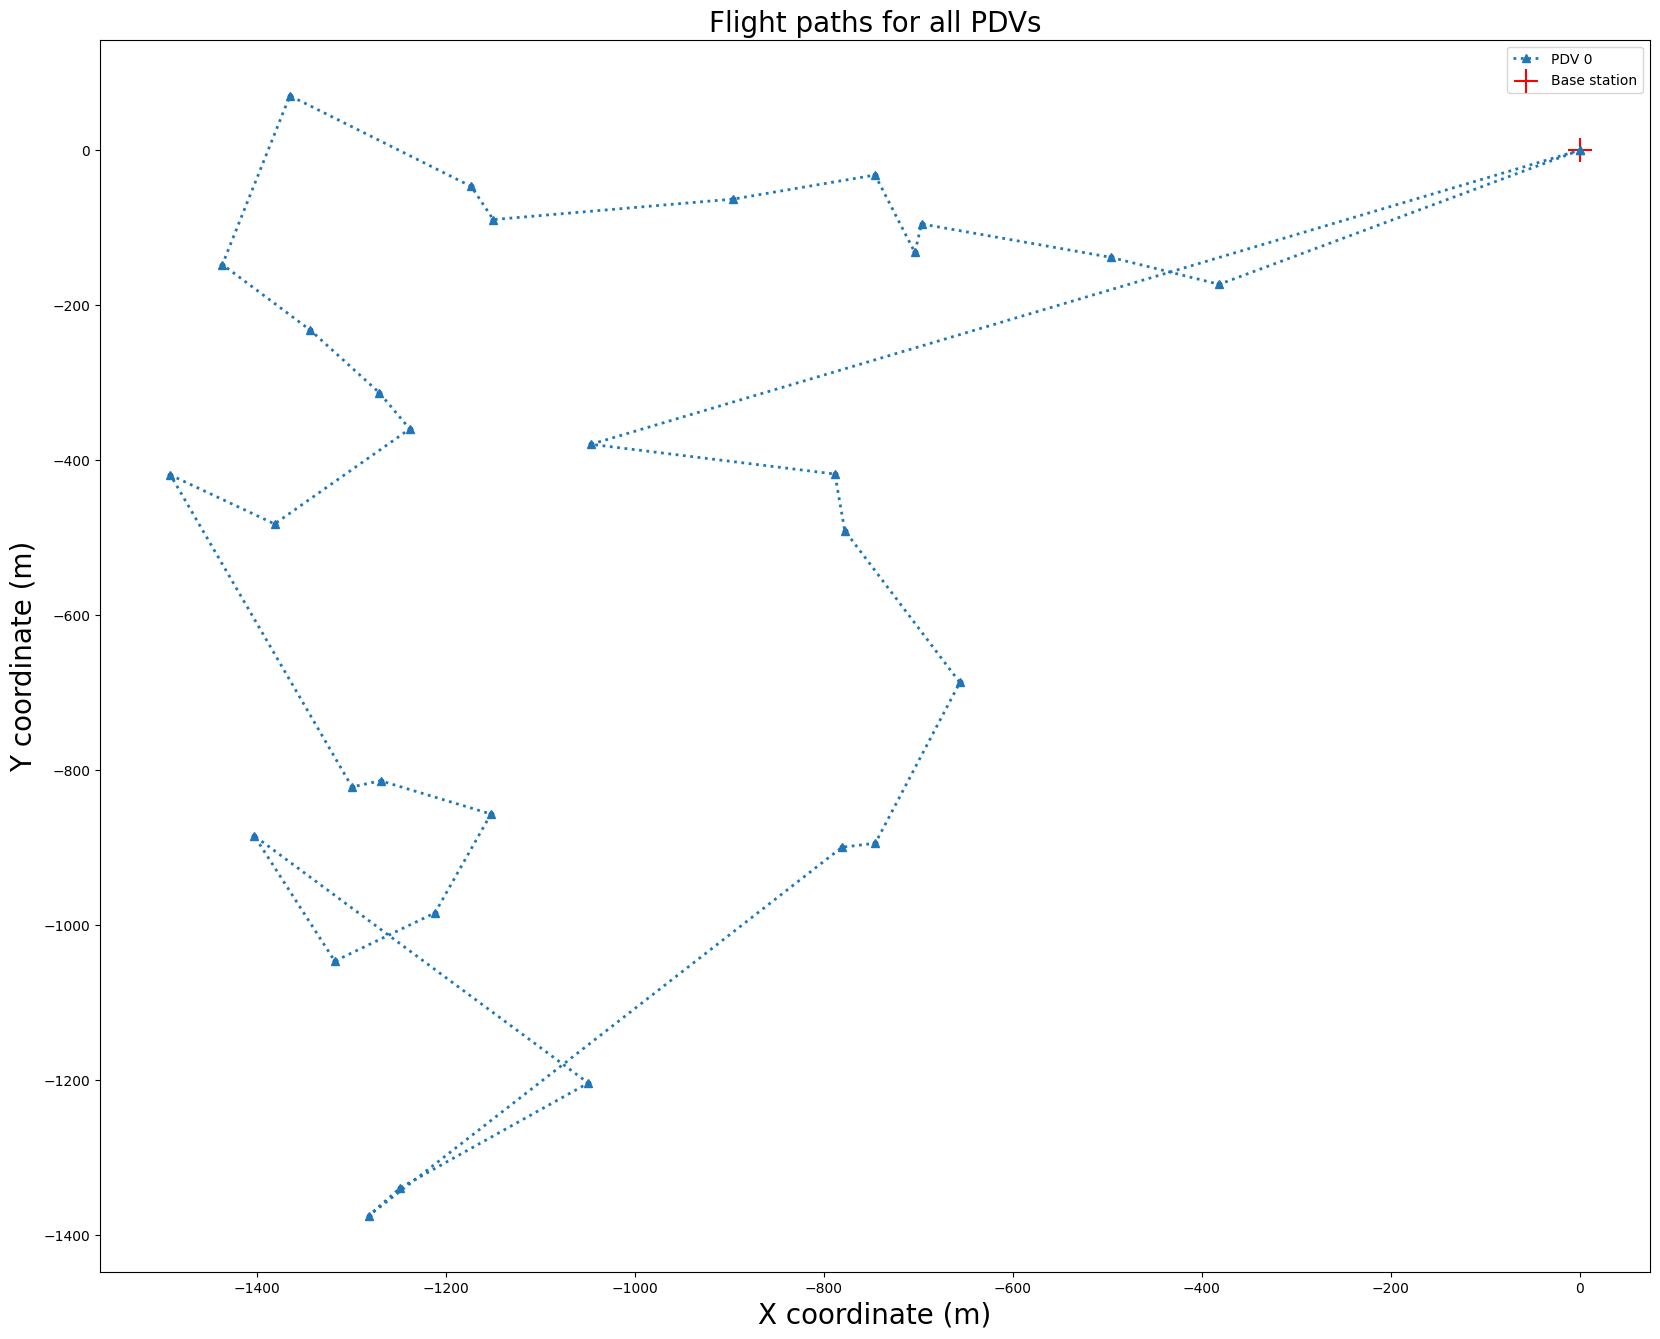

Total flight distance: 6854.02 m


In [63]:
def flight_simulation(file_num, in_path="../output/sub_path", method="SJN"):
    """
    Visualize the flight paths. Note that this function DOES NOT consider if the P
    DV can finish the path, it only calculates the flight distance.
    
    Parameters
    ----------
    file_num : scalar
        The number of files to be read.
        
    in_path : string
        The path to store read file.
        Default is "../output/sub_path/ga_path"
    
    method : string
        There are two option: "SJN" and "SO". "SJN" means draw all flight paths
        following "SJN" strategy and "SO" means squence order, which follows the 
        original order of Points stored in the list.
    """
    
    xmin, xmax, ymin, ymax, data = loadData(file_num=file_num, in_path=in_path)
    
    all_p = list(itertools.chain(*data))
    all_p = convertPointsToArray(all_p)
    origin = Point(0., 0.)
    total_flight_d = 0
    
    final_all_ps = []
    
    for i in range(1):        
        p1 = origin
        total_d = 0
        sorted_flight_path = [p1]
        
        if method == "SJN":
            while len(data[i]) != 0:
                next = 0
                temp_d = p1.calcDistance(data[i][next].x, data[i][next].y)
                for j in range(1, len(data[i])):
                    curr_d = p1.calcDistance(data[i][j].x, data[i][j].y)
                    if curr_d < temp_d:
                        temp_d = curr_d
                        next = j

                p1 = Point(data[i][next].x, data[i][next].y)
                sorted_flight_path.append(p1)
                del data[i][next]
                total_d += temp_d
        
        if method == "SO":
            for j in range(len(data[i])):
                temp_d = p1.calcDistance(data[i][j].x, data[i][j].y)
                total_d += temp_d
                p1 = Point(data[i][j].x, data[i][j].y)
                sorted_flight_path.append(Point(data[i][j].x, data[i][j].y))
            
        sorted_flight_path.append(origin)
        total_d += p1.calcDistance(0., 0.)
        total_flight_d += total_d
        sorted_flight_path = convertPointsToArray(sorted_flight_path)
        print("For PDV ID: %i, total flight distance is: %.2f m" % (i, total_d))
        final_all_ps.append(sorted_flight_path)

    # Uncomment following commands to see departure and RTH process.
    fig = plt.figure(figsize=(20, 16))
    for i in range(file_num):
#         plt.plot(final_all_ps[i][:2, 0], final_all_ps[i][:2, 1], 'r-', linewidth=2, label='PDV %i Departure process'%i)
        plt.plot(final_all_ps[i][:, 0], final_all_ps[i][:, 1], '^:', linewidth=2, label='PDV %i'%i)
#         plt.plot(final_all_ps[i][-2:, 0], final_all_ps[i][-2:, 1], 'b-', linewidth=2, label='PDV %i RTH process'%i)

    
    plt.scatter(all_p[:, 0], all_p[:, 1], c='b', s=10)
    plt.scatter(0., 0., s=300, c='r', marker='+', label='Base station')
    plt.legend()
    plt.xlabel('X coordinate (m)', fontsize=20)
    plt.ylabel('Y coordinate (m)', fontsize=20)
    plt.title('Flight paths for all PDVs', fontsize=20)
    plt.show()
    print('Total flight distance: %.2f m'%total_flight_d)

# 
flight_simulation(file_num=1, method="SJN")    

## 3.6. Generate and save animation of complete flight paths

In [64]:
def generate_animation(file_num, in_path="../output/sub_path", 
                       out_path="../output/complete_flight_path.gif", method="SJN"):
    """
    Visualize the flight paths. Note that this function DOES NOT consider if the P
    DV can finish the path, it only calculates the flight distance.
    
    Parameters
    ----------
    file_num : scalar
        The number of files to be read.
        
    in_path : string
        The path to store read file.
        Default is "../output/sub_path/ga_path"
    
    method : string
        There are two option: "SJN" and "SO". "SJN" means draw all flight paths
        following "SJN" strategy and "SO" means squence order, which follows the 
        original order of Points stored in the list.
    """
    
    xmin, xmax, ymin, ymax, data = loadData(file_num=file_num, in_path=in_path)
    limit = (xmin, xmax, ymin, ymax)
    all_p = list(itertools.chain(*data))
    all_p = convertPointsToArray(all_p)
    origin = Point(0., 0.)
    total_flight_d = 0
    
    final_all_ps = []
    
    for i in range(1):        
        p1 = origin
        total_d = 0
        sorted_flight_path = [p1]
        
        if method == "SJN":
            while len(data[i]) != 0:
                next = 0
                temp_d = p1.calcDistance(data[i][next].x, data[i][next].y)
                for j in range(1, len(data[i])):
                    curr_d = p1.calcDistance(data[i][j].x, data[i][j].y)
                    if curr_d < temp_d:
                        temp_d = curr_d
                        next = j

                p1 = Point(data[i][next].x, data[i][next].y)
                sorted_flight_path.append(p1)
                del data[i][next]
                total_d += temp_d
        
        if method == "SO":
            for j in range(len(data[i])):
                temp_d = p1.calcDistance(data[i][j].x, data[i][j].y)
                total_d += temp_d
                p1 = Point(data[i][j].x, data[i][j].y)
                sorted_flight_path.append(Point(data[i][j].x, data[i][j].y))
            
        sorted_flight_path.append(origin)
        total_d += p1.calcDistance(0., 0.)
        total_flight_d += total_d
        sorted_flight_path = convertPointsToArray(sorted_flight_path)
        final_all_ps.append(sorted_flight_path)
        
    fig = plt.figure(figsize=(16,14))
    base = plt.imread("../output/farm.jpeg")
    imgs = []
    for i in range(1):
        for j in range(len(final_all_ps[i])):
            plt.imshow(base, zorder=0, extent=limit, aspect='equal')
            im = plt.scatter(all_p[:, 0], all_p[:, 1], c='b', s=10)
            if j == 0:
                im = plt.plot(final_all_ps[i][0, 0], final_all_ps[i][0, 1], 'r^-', linewidth=3)
            if j == len(final_all_ps[i]) - 1:
                im = plt.plot(final_all_ps[i][:, 0], final_all_ps[i][:, 1], 'r^-', linewidth=3)
            else:
                im = plt.plot(final_all_ps[i][:j, 0], final_all_ps[i][:j, 1], 'r^-', linewidth=3)

            plt.xlabel('X coordinate (m)', fontsize=20)
            plt.ylabel('Y coordinate (m)', fontsize=20)
            plt.title('Complete Flight paths of all PDVs', fontsize=20)
            imgs.append(im)
    
    anis = ani.ArtistAnimation(fig, imgs, interval=8000, repeat_delay=10000)
    writer = PillowWriter(fps=2)
    anis.save(out_path, writer=writer)
    
    plt.close()

In [65]:
generate_animation(file_num=file_num)

## 3.7. Ensemble data visualization through histogram

Please note that the ensemble output CSV file cannot be automatically generated by code. If you want to test this block, please create your own data! See sample ensemble output file in the Github repository.

In [66]:
def generate_line_graph(in_path="../output/ensemble_output.csv", plot_all=False):
    ensemble = pd.read_csv(in_path)
    cases = np.arange(9) + 1
    bar_width=0.2
    
    bh_dist = ensemble['Distance'][ensemble['Alg'] == 'BH'].to_numpy()
    ga_dist = ensemble['Distance'][ensemble['Alg'] == 'GA'].to_numpy()
    sa_dist = ensemble['Distance'][ensemble['Alg'] == 'SA'].to_numpy()
    
    bh_thro = ensemble['Throughput'][ensemble['Alg'] == 'BH'].to_numpy()
    ga_thro = ensemble['Throughput'][ensemble['Alg'] == 'GA'].to_numpy()
    sa_thro = ensemble['Throughput'][ensemble['Alg'] == 'SA'].to_numpy()
    
    bh_cost = ensemble['Energy Cost'][ensemble['Alg'] == 'BH'].to_numpy()
    ga_cost = ensemble['Energy Cost'][ensemble['Alg'] == 'GA'].to_numpy()
    sa_cost = ensemble['Energy Cost'][ensemble['Alg'] == 'SA'].to_numpy()
    
    bh_rech = ensemble['Charged Energy'][ensemble['Alg'] == 'BH'].to_numpy()
    ga_rech = ensemble['Charged Energy'][ensemble['Alg'] == 'GA'].to_numpy()
    sa_rech = ensemble['Charged Energy'][ensemble['Alg'] == 'SA'].to_numpy()

    bh_exec = ensemble['exe_t'][ensemble['Alg'] == 'BH'].to_numpy() / 1000.
    ga_exec = ensemble['exe_t'][ensemble['Alg'] == 'GA'].to_numpy() / 1000.
    sa_exec = ensemble['exe_t'][ensemble['Alg'] == 'SA'].to_numpy() / 1000.
    
    if plot_all:
        fig1 = plt.subplots(figsize=(16,10))
        plt.bar(x=np.arange(len(cases)) - bar_width, height=sa_dist, label='SA', color='indigo', alpha=0.8, width=bar_width)
        plt.bar(x=range(len(cases)), height=ga_dist, label='GA', color='seagreen', alpha=0.8, width=bar_width)
        plt.bar(x=np.arange(len(cases)) + bar_width, height=bh_dist, label='BH', color='orange', alpha=0.8, width=bar_width)
        plt.xticks(np.arange(len(cases)) + bar_width/3, cases)
        plt.legend()
        plt.xlabel('Case', fontsize=14)
        plt.ylabel('Distance (m)', fontsize=14)
        plt.ylim(5000, 45000)
        plt.title('Total Flight Distance Comparison', fontsize=20)
        plt.show()
        
        fig2 = plt.subplots(figsize=(16,10))
        plt.bar(x=np.arange(len(cases)) - bar_width, height=sa_thro, label='SA', color='indigo', alpha=0.8, width=bar_width)
        plt.bar(x=range(len(cases)), height=ga_thro, label='GA', color='seagreen', alpha=0.8, width=bar_width)
        plt.bar(x=np.arange(len(cases)) + bar_width, height=bh_thro, label='BH', color='orange', alpha=0.8, width=bar_width)
        plt.xticks(np.arange(len(cases)) + bar_width/3, cases)
        plt.legend()
        plt.xlabel('Case', fontsize=14)
        plt.ylabel('Throughput (%)', fontsize=14)
        plt.ylim(80, 102)
        plt.title('Average Throughput Comparison', fontsize=20)
        plt.show()
        
        fig3 = plt.subplots(figsize=(16,10))
        plt.bar(x=np.arange(len(cases)) - bar_width, height=sa_cost, label='SA', color='indigo', alpha=0.8, width=bar_width)
        plt.bar(x=range(len(cases)), height=ga_cost, label='GA', color='seagreen', alpha=0.8, width=bar_width)
        plt.bar(x=np.arange(len(cases)) + bar_width, height=bh_cost, label='BH', color='orange', alpha=0.8, width=bar_width)
        plt.xticks(np.arange(len(cases)) + bar_width/3, cases)
        plt.legend()
        plt.xlabel('Case', fontsize=14)
        plt.ylabel('Energy Cost (Wh)', fontsize=14)
        plt.ylim(100, 780)
        plt.title('Total Energy Cost Comparison', fontsize=20)
        plt.show()
        
        fig4 = plt.subplots(figsize=(16,10))
        plt.bar(x=np.arange(len(cases)) - bar_width, height=sa_rech, label='SA', color='indigo', alpha=0.8, width=bar_width)
        plt.bar(x=range(len(cases)), height=ga_rech, label='GA', color='seagreen', alpha=0.8, width=bar_width)
        plt.bar(x=np.arange(len(cases)) + bar_width, height=bh_rech, label='BH', color='orange', alpha=0.8, width=bar_width)
        plt.xticks(np.arange(len(cases)) + bar_width/3, cases)
        plt.legend()
        plt.xlabel('Case', fontsize=14)
        plt.ylabel('Recharged Energy (J)', fontsize=14)
        plt.ylim(1000, 4600)
        plt.title('Total Recharged Energy Comparison', fontsize=20)
        plt.show() 
        
        fig5 = plt.subplots(figsize=(16,10))
        plt.bar(x=np.arange(len(cases)) - bar_width, height=sa_exec, label='SA', color='indigo', alpha=0.8, width=bar_width)
        plt.bar(x=range(len(cases)), height=ga_exec, label='GA', color='seagreen', alpha=0.8, width=bar_width)
        plt.bar(x=np.arange(len(cases)) + bar_width, height=bh_exec, label='BH', color='orange', alpha=0.8, width=bar_width)
        plt.xticks(np.arange(len(cases)) + bar_width/3, cases)
        plt.legend()
        plt.xlabel('Case', fontsize=14)
        plt.ylabel('Execution Time (s)', fontsize=14)
        plt.ylim(100, 1750)
        plt.title('Average Execution Time Comparison', fontsize=20)
        plt.show() 

In [67]:
generate_line_graph(in_path=ensemble_path, plot_all=True)

KeyError: 'Distance'